In [ ]:
!git clone https://github.com/chandrikadeb7/Face-Mask-Detection.git

Cloning into 'Face-Mask-Detection'...
remote: Enumerating objects: 4590, done.
remote: Total 4590 (delta 0), reused 0 (delta 0), pack-reused 4590
Receiving objects: 100% (4590/4590), 186.72 MiB | 43.33 MiB/s, done.
Resolving deltas: 100% (271/271), done.
Checking out files: 100% (4155/4155), done.


In [ ]:
import numpy as np
from imutils import paths
import os

In [ ]:
imagePaths = list(paths.list_images('/content/Face-Mask-Detection/dataset'))

In [ ]:
imagePaths[0]

'/content/Face-Mask-Detection/dataset/without_mask/0_0_zhangbo_0064.jpg'

In [ ]:
label = imagePaths[0].split(os.path.sep)[-2]
label

'without_mask'

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

In [ ]:
data = []
labels = []

IMG_SIZE = 224
CHANNELS = 3

for imagePath in imagePaths:
  label = imagePath.split(os.path.sep)[-2]
  image = load_img(imagePath, target_size=(IMG_SIZE, IMG_SIZE))
  image = img_to_array(image)
  image = image/255

  data.append(image)
  labels.append(label)


data = np.array(data, dtype="float32")
labels = np.array(labels)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
data.shape

(4092, 224, 224, 3)

In [ ]:
labels.shape

(4092,)

In [ ]:
labels[0]

1

In [ ]:
np. unique(labels, return_counts=True)

(array(['with_mask', 'without_mask'], dtype='<U12'), array([2162, 1930]))

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
labels = le.fit_transform(labels)

In [ ]:
labels[2000]

0

In [ ]:
from tensorflow.keras.utils import to_categorical
labels = to_categorical(labels)

In [ ]:
labels[0]

array([0., 1.], dtype=float32)

In [ ]:
from sklearn.model_selection import train_test_split
(trainX, testX, trainY, testY) = train_test_split(data, labels,	test_size=0.20, stratify=labels, random_state=42)

In [ ]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Input

In [ ]:
feature_extractor_layer = ResNet50V2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(IMG_SIZE,IMG_SIZE,CHANNELS)))

94668760/94668760 [==============================] - 1s 0us/step


In [ ]:
feature_extractor_layer.trainable = False

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

In [ ]:
model = tf.keras.Sequential()
model.add(feature_extractor_layer)
model.add(layers.Flatten(name="flatten"))
model.add(layers.Dense(1024, activation='relu', name='hidden_layer'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax', name='output'))


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 hidden_layer (Dense)        (None, 1024)              102761472 
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 output (Dense)              (None, 2)                 2050      
                                                                 
Total params: 126,328,322
Trainable params: 102,763,522
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
  loss="categorical_crossentropy",
  metrics=["accuracy"])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [ ]:
history = model.fit(aug.flow(trainX, trainY),
	                  validation_data=(testX, testY),
	                  epochs=10)

Epoch 1/10
103/103 [==============================] - 50s 381ms/step - loss: 0.1447 - accuracy: 0.9597 - val_loss: 0.0500 - val_accuracy: 0.9939
Epoch 2/10
103/103 [==============================] - 38s 365ms/step - loss: 0.0626 - accuracy: 0.9841 - val_loss: 0.0489 - val_accuracy: 0.9939
Epoch 3/10
103/103 [==============================] - 37s 361ms/step - loss: 0.0337 - accuracy: 0.9905 - val_loss: 0.0508 - val_accuracy: 0.9939
Epoch 4/10
103/103 [==============================] - 36s 353ms/step - loss: 0.0430 - accuracy: 0.9902 - val_loss: 0.0486 - val_accuracy: 0.9963
Epoch 5/10
103/103 [==============================] - 38s 367ms/step - loss: 0.0499 - accuracy: 0.9893 - val_loss: 0.0473 - val_accuracy: 0.9951
Epoch 6/10
103/103 [==============================] - 36s 352ms/step - loss: 0.0356 - accuracy: 0.9914 - val_loss: 0.0417 - val_accuracy: 0.9976
Epoch 7/10
103/103 [==============================] - 36s 349ms/step - loss: 0.0164 - accuracy: 0.9945 - val_loss: 0.0464 - val_ac

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
predIdxs = model.predict(testX)

26/26 [==============================] - 3s 84ms/step


In [ ]:
predIdxs[0]

array([1.0000000e+00, 6.5407712e-31], dtype=float32)

In [ ]:
predIdxs = np.argmax(predIdxs, axis=1)

In [ ]:
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=le.classes_))

              precision    recall  f1-score   support

   with_mask       1.00      1.00      1.00       433
without_mask       0.99      1.00      1.00       386

    accuracy                           1.00       819
   macro avg       1.00      1.00      1.00       819
weighted avg       1.00      1.00      1.00       819



In [ ]:
model.save('model_mask_detctor.h5', save_format="h5")

In [ ]:
model = tf.keras.models.load_model('/content/model_mask_detctor.h5')

In [ ]:
image = load_img('/content/40199740-4_1-care-4-all-face-mask-5-layer-in-multicolor-without-valve.webp',target_size=(IMG_SIZE, IMG_SIZE))
image = img_to_array(image)
image = image/255

In [ ]:
image.shape

(224, 224, 3)

In [ ]:
pred = model.predict(image.reshape(1,224,224,3))

1/1 [==============================] - 0s 32ms/step


In [ ]:
pred

array([[1.8292356e-07, 9.9999976e-01]], dtype=float32)

In [ ]:
np.argmax(pred, axis=1)

array([0])

In [ ]:
le.classes_[0]

'with_mask'

# **MTCNN Face detctor**

In [ ]:
pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 4.7 MB/s 


In [ ]:
from mtcnn.mtcnn import MTCNN

In [ ]:
import cv2

In [ ]:
imagePath = '/content/Face-Mask-Detection/images/pic2.jpg'

image = cv2.imread(imagePath)
image1 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:
detector = MTCNN()

faces = detector.detect_faces(image1)
faces

1/1 [==============================] - 0s 117ms/step


[{'box': [366, 68, 155, 190],
  'confidence': 1.0,
  'keypoints': {'left_eye': (416, 136),
   'right_eye': (488, 137),
   'nose': (452, 178),
   'mouth_left': (416, 207),
   'mouth_right': (478, 209)}},
 {'box': [63, 100, 147, 193],
  'confidence': 0.9999799728393555,
  'keypoints': {'left_eye': (101, 174),
   'right_eye': (174, 174),
   'nose': (138, 207),
   'mouth_left': (109, 247),
   'mouth_right': (165, 247)}},
 {'box': [616, 103, 137, 183],
  'confidence': 0.9981901049613953,
  'keypoints': {'left_eye': (646, 171),
   'right_eye': (712, 170),
   'nose': (672, 202),
   'mouth_left': (650, 243),
   'mouth_right': (707, 242)}},
 {'box': [674, 0, 131, 141],
  'confidence': 0.9816129207611084,
  'keypoints': {'left_eye': (731, 49),
   'right_eye': (779, 43),
   'nose': (769, 75),
   'mouth_left': (744, 103),
   'mouth_right': (783, 100)}}]

In [ ]:
faces[0]['box']

[366, 68, 155, 190]

In [ ]:
from google.colab.patches import cv2_imshow

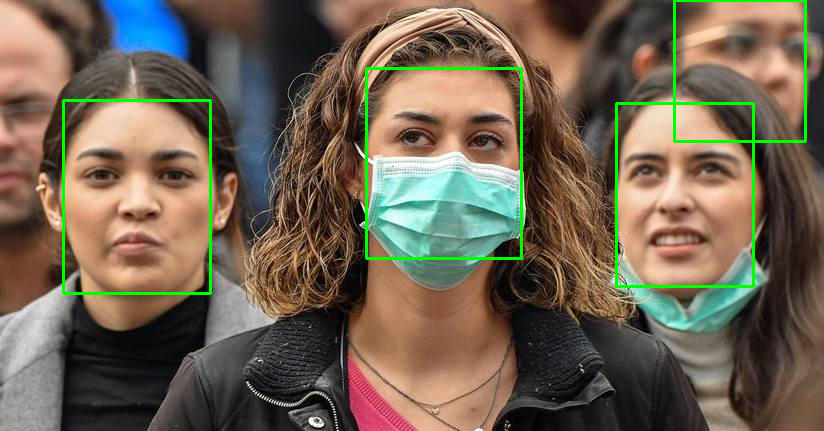

In [ ]:
for face in faces:
  x,y,w,h = face['box']
  cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

cv2_imshow(image)

# **Complete Code**

1/1 [==============================] - 0s 147ms/step


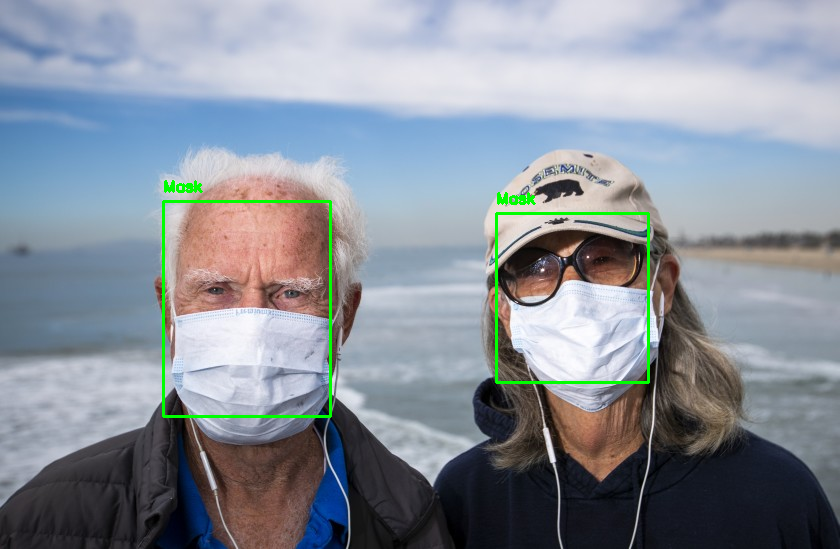

In [ ]:
imagePath = '/content/Face-Mask-Detection/images/pic1.jpeg'

image = cv2.imread(imagePath)
image1 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
detector = MTCNN()

faces = detector.detect_faces(image1)



for face in faces:
  (x, y, w, h) = face['box']
  roi_color = image[y:y + h, x:x + w]
  roi = cv2.resize(roi_color, (224, 224))
  roi = roi/255
  pred = model.predict(roi.reshape(1,224,224,3),verbose=0)
  if(np.argmax(pred, axis=1)==0):
    #mask : Green
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(image, 'Mask', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
  else:
    #No mask : Red
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)
    cv2.putText(image, 'No Mask', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 2)
  
cv2_imshow(image)

# **Video Capture**

In [ ]:
vid = cv2.VideoCapture(0)
  
while(True):
      
    # Capture the video frame
    # by frame
    ret, frame = vid.read()
  
    # Display the resulting frame
    cv2.imshow('frame', frame)
      
    # the 'q' button is set as the
    # quitting button you may use any
    # desired button of your choice
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
  
# After the loop release the cap object
vid.release()
# Destroy all the windows
cv2.destroyAllWindows()